Вместе датасета, который невозможно скачать, по согласованию с преподавателем взят более простой датасет

In [1]:
import torch 
import torch.nn as nn 

import seaborn as sns 
import numpy as np 
import pandas as pd 

from sklearn.preprocessing import MinMaxScaler

import matplotlib.pyplot as plt 
%matplotlib inline 

In [2]:
class LSTM(nn.Module):
    def __init__(self, input_size=1, hidden_layer_size=100, output_size=1):
        super().__init__()
        self.hidden_layer_size = hidden_layer_size

        self.lstm = nn.LSTM(input_size, hidden_layer_size)

        self.linear = nn.Linear(hidden_layer_size, output_size)

        self.hidden_cell = (torch.zeros(1,1,self.hidden_layer_size),
                            torch.zeros(1,1,self.hidden_layer_size))

    def forward(self, input_seq):
        lstm_out, self.hidden_cell = self.lstm(input_seq.view(len(input_seq) ,1, -1), self.hidden_cell)
        predictions = self.linear(lstm_out.view(len(input_seq), -1))
        return predictions[-1]

def create_inout_sequences(input_data, tw):
    inout_seq = []
    L = len(input_data)
    for i in range(L-tw):
        train_seq = input_data[i:i+tw]
        train_label = input_data[i+tw:i+tw+1]
        inout_seq.append((train_seq ,train_label))
    return inout_seq

In [3]:
flight_data = sns.load_dataset("flights")
flight_data.head()

,year,month,passengers
0,1949,Jan,112
1,1949,Feb,118
2,1949,Mar,132
3,1949,Apr,129
4,1949,May,121


In [4]:
flight_data.describe().T

,count,mean,std,min,25%,50%,75%,max
year,144.0,1954.500000,3.464102,1949.0,1951.75,1954.5,1957.25,1960.0
passengers,144.0,280.298611,119.966317,104.0,180.00,265.5,360.50,622.0


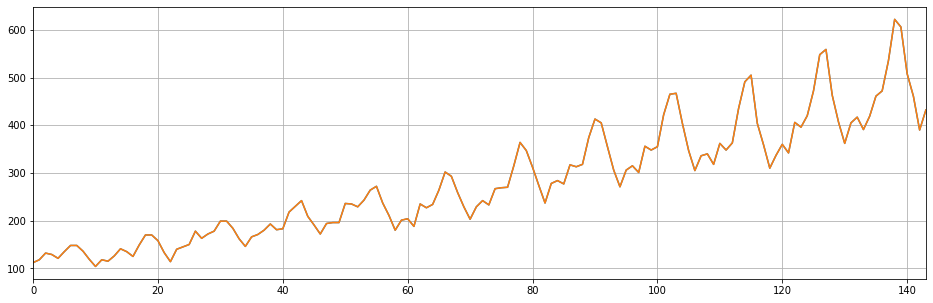

In [5]:
flight_data['passengers'].plot( figsize = (16,5))
plt.grid(True)
plt.autoscale(axis='x',tight=True)
plt.plot(flight_data['passengers'])


Визуально наблюдаем рост пассажиропотока на фоне периодических колебаний (предположительно сезонных)

In [6]:
all_data = flight_data['passengers'].values.astype(float)
test_data_size = 12 #величина тестовой выборки
train_data = all_data[:-test_data_size]
test_data = all_data[-test_data_size:]

In [7]:
scaler = MinMaxScaler(feature_range=(-1, 1))
train_data_normalized = scaler.fit_transform(train_data .reshape(-1, 1))
train_data_normalized = torch.FloatTensor(train_data_normalized).view(-1)
train_window = 12



In [8]:
train_inout_seq = create_inout_sequences(train_data_normalized, train_window)



In [53]:
model = LSTM()
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0011)

In [54]:
epochs = 100

for i in range(epochs):
    for seq, labels in train_inout_seq:
        optimizer.zero_grad()
        model.hidden_cell = (torch.zeros(1, 1, model.hidden_layer_size),
                        torch.zeros(1, 1, model.hidden_layer_size))

        y_pred = model(seq)

        single_loss = loss_function(y_pred, labels)
        single_loss.backward()
        optimizer.step()

    if i%10 == 0:
        print(f'epoch: {i:3} loss: {single_loss.item():10.8f}')

print(f'epoch: {i:3} loss: {single_loss.item():10.10f}')



epoch:   0 loss: 0.01413008
epoch:  10 loss: 0.05336586
epoch:  20 loss: 0.01409761
epoch:  30 loss: 0.00536914
epoch:  40 loss: 0.00000017
epoch:  50 loss: 0.00410206
epoch:  60 loss: 0.01020451
epoch:  70 loss: 0.00981449
epoch:  80 loss: 0.01029469
epoch:  90 loss: 0.00414242
epoch:  99 loss: 0.0004037236


In [55]:
fut_pred = 12

test_inputs = train_data_normalized[-train_window:].tolist()
print(test_inputs)

model.eval()

for i in range(fut_pred):
    seq = torch.FloatTensor(test_inputs[-train_window:])
    with torch.no_grad():
        model.hidden = (torch.zeros(1, 1, model.hidden_layer_size),
                        torch.zeros(1, 1, model.hidden_layer_size))
        test_inputs.append(model(seq).item())

actual_predictions = scaler.inverse_transform(np.array(test_inputs[train_window:] ).reshape(-1, 1))



[0.12527473270893097, 0.04615384712815285, 0.3274725377559662, 0.2835164964199066, 0.3890109956264496, 0.6175824403762817, 0.9516483545303345, 1.0, 0.5780220031738281, 0.33186814188957214, 0.13406594097614288, 0.32307693362236023]


In [56]:
x = np.arange(132, 144, 1)

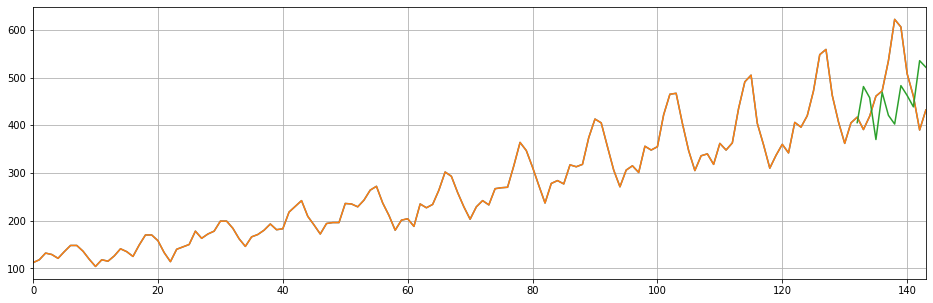

In [57]:


flight_data['passengers'].plot( figsize = (16,5))
plt.grid(True)
plt.autoscale(axis='x',tight=True)
plt.plot(flight_data['passengers'])
plt.plot(x,actual_predictions)
plt.show()

Алгоритм в целом правильно уловил тенденцию к росту и колебанию числа пассажиров, но слабо уловил сезонность.